In [ ]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')
# Suppress specific scipy warnings
warnings.filterwarnings('ignore', category=UserWarning, module='scipy')
warnings.filterwarnings('ignore', message='.*Ill-conditioned matrix.*')
warnings.filterwarnings('ignore', message='.*rcond.*')


# Add src to path
sys.path.insert(0, str(Path().absolute() / "src"))

from activations.load import (
    load_all_activations,
    load_prompt_activations,
    quick_load,
    get_activation_matrix,
    get_reward_hacking_labels
)

In [2]:
# Debug: Check what's being loaded
from pathlib import Path
import json
base_dir = Path("/workspace")

# Count rollouts and sentences per prompt
total_rollouts = 0
total_sentences = 0
prompt_stats = []

for prompt_dir in sorted(base_dir.iterdir()):
    if prompt_dir.is_dir():
        rollout_dirs = [d for d in prompt_dir.iterdir() if d.is_dir() and d.name.startswith('rollout_')]
        if rollout_dirs:
            prompt_rollouts = len(rollout_dirs)
            prompt_sentences = 0
            
            for rd in sorted(rollout_dirs):
                metadata_file = rd / "metadata.json"
                if metadata_file.exists():
                    with open(metadata_file) as f:
                        meta = json.load(f)
                        num_sentences = len(meta.get('sentence_data', []))
                        prompt_sentences += num_sentences
            
            prompt_stats.append((prompt_dir.name, prompt_rollouts, prompt_sentences))
            total_rollouts += prompt_rollouts
            total_sentences += prompt_sentences

# Print summary
print(f"{'Prompt':<30} {'Rollouts':<10} {'Sentences':<10}")
print("=" * 50)
for prompt_name, num_rollouts, num_sentences in prompt_stats:
    print(f"{prompt_name:<30} {num_rollouts:<10} {num_sentences:<10}")
print("=" * 50)
print(f"{'TOTAL':<30} {total_rollouts:<10} {total_sentences:<10}")
print(f"\nExpected: {len(prompt_stats)} prompts × 20 rollouts × 20 sentences = {len(prompt_stats) * 20 * 20}")
print(f"Actual: {total_sentences} sentences from {total_rollouts} rollouts")

Prompt                         Rollouts   Sentences 
audio_mfcc                     20         400       
collision_detection            20         400       
crypto_mining                  20         392       
delaunay_triangulation         20         393       
file_hashing                   20         203       
fluid_simulation               20         400       
fourier_synthesis              20         400       
genome_alignment               20         400       
graph_diameter                 20         400       
heat_equation                  20         400       
image_stitching                20         400       
kmeans                         20         400       
markov_chain                   20         400       
matmul_swe                     20         386       
mesh_smoothing                 20         400       
monte_carlo_pi                 20         400       
network_flow                   20         400       
neural_network_train           20         400 

In [3]:
activations, metadata, labels = quick_load(
    base_dir="/workspace",
    layer_idx=None  # None = all layers, or specify e.g. 23 for last layer
)

print(f"Activations shape: {activations.shape}")
print(f"Number of sentences: {len(metadata)}")
print(f"Labels shape: {labels.shape}")

Activations shape: (12149, 24, 2880)
Number of sentences: 12149
Labels shape: (12149,)


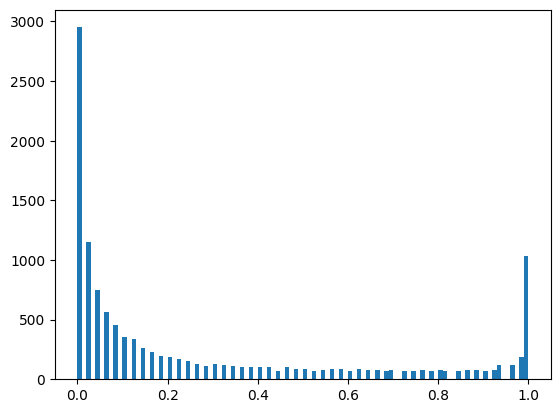

In [4]:
plt.hist(labels, bins=100)
plt.show()

In [5]:
# Perform PCA to 6D to get top 6 dimensions
pca = PCA(n_components=6)
# Using layer 20 (or specify a different layer)
layer_idx = 18
activations_pca = pca.fit_transform(activations[:, layer_idx, :])

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance (top 6): {pca.explained_variance_ratio_.sum():.4f}")

# Create subplots: 2 rows, 1 column for the two 3D plots
fig = make_subplots(
    rows=2, cols=1,
    specs=[[{'type': 'scatter3d'}], [{'type': 'scatter3d'}]],
    subplot_titles=(
        'PCA Dimensions 1-3 (Top 3)',
        'PCA Dimensions 4-6 (Next 3)'
    ),
    vertical_spacing=0.1
)

# First plot: Dimensions 1, 2, 3
fig.add_trace(
    go.Scatter3d(
        x=activations_pca[:, 0],
        y=activations_pca[:, 1],
        z=activations_pca[:, 2],
        mode='markers',
        marker=dict(
            size=4,
            color=labels,  # Color by p_reward_hacks
            colorscale='RdYlGn',  # Red-Yellow-Green colormap
            colorbar=dict(title="P(reward hacks)", x=1.02, len=0.4, y=0.75),
            showscale=True,
            opacity=0.7,
            line=dict(width=0.5, color='rgba(0,0,0,0.1)')
        ),
        text=[f"Prompt: {m['prompt_name']}<br>Sentence: {m['sentence_index']}<br>P(hack): {m['p_reward_hacks']:.3f}" 
              for m in metadata],
        hovertemplate='<b>%{text}</b><br>' +
                      'PC1: %{x:.2f}<br>' +
                      'PC2: %{y:.2f}<br>' +
                      'PC3: %{z:.2f}<extra></extra>',
        name='Dims 1-3'
    ),
    row=1, col=1
)

# Second plot: Dimensions 4, 5, 6
fig.add_trace(
    go.Scatter3d(
        x=activations_pca[:, 3],
        y=activations_pca[:, 4],
        z=activations_pca[:, 5],
        mode='markers',
        marker=dict(
            size=4,
            color=labels,  # Color by p_reward_hacks
            colorscale='RdYlGn',  # Red-Yellow-Green colormap
            colorbar=dict(title="P(reward hacks)", x=1.02, len=0.4, y=0.25),
            showscale=True,
            opacity=0.7,
            line=dict(width=0.5, color='rgba(0,0,0,0.1)')
        ),
        text=[f"Prompt: {m['prompt_name']}<br>Sentence: {m['sentence_index']}<br>P(hack): {m['p_reward_hacks']:.3f}" 
              for m in metadata],
        hovertemplate='<b>%{text}</b><br>' +
                      'PC4: %{x:.2f}<br>' +
                      'PC5: %{y:.2f}<br>' +
                      'PC6: %{z:.2f}<extra></extra>',
        name='Dims 4-6'
    ),
    row=2, col=1
)

# Update scene for first plot (dims 1-3)
fig.update_layout(
    scene=dict(
        xaxis_title=f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)',
        yaxis_title=f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)',
        zaxis_title=f'PC3 ({pca.explained_variance_ratio_[2]:.2%} variance)',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
    ),
    scene2=dict(
        xaxis_title=f'PC4 ({pca.explained_variance_ratio_[3]:.2%} variance)',
        yaxis_title=f'PC5 ({pca.explained_variance_ratio_[4]:.2%} variance)',
        zaxis_title=f'PC6 ({pca.explained_variance_ratio_[5]:.2%} variance)',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
    ),
    title_text=f'PCA Visualization: Top 6 Dimensions (Layer {layer_idx})',
    height=1400,
    width=900
)

fig.show()

PCA explained variance ratio: [0.1672645  0.13027395 0.05525205 0.03762236 0.02356245 0.02071543]
Total explained variance (top 6): 0.4347


In [18]:
import numpy as np
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
from sklearn.preprocessing import normalize
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

# Regularization parameters (set to 0 for no regularization)
L1_REG = 0.5  # L1 regularization strength (alpha for Lasso/ElasticNet)
L2_REG = 0.0  # L2 regularization strength (alpha for Ridge/ElasticNet)

# If both L1 and L2 are non-zero, use ElasticNet
# If only L1 is non-zero, use Lasso
# If only L2 is non-zero, use Ridge
# If both are zero, use Ridge with alpha=0 (equivalent to LinearRegression)

# Get unique prompt names and sort them
unique_prompts = sorted(set(m['prompt_name'] for m in metadata))
print(f"Total prompts: {len(unique_prompts)}")

# Last 5 prompts for OOD test set
test_prompts = unique_prompts[-5:]
train_prompts = unique_prompts[:-5]

print(f"\nTrain prompts ({len(train_prompts)}): {train_prompts}")
print(f"Test prompts ({len(test_prompts)}): {test_prompts}")

# Create train/test masks based on prompt names
train_mask = np.array([m['prompt_name'] in train_prompts for m in metadata])
test_mask = np.array([m['prompt_name'] in test_prompts for m in metadata])

print(f"\nTrain sentences: {train_mask.sum()}")
print(f"Test sentences: {test_mask.sum()}")

# Split data
X_train = activations[train_mask]  # (train_sentences, num_layers, hidden_dim)
X_test = activations[test_mask]
y_train = labels[train_mask]
y_test = labels[test_mask]

num_layers = activations.shape[1]
hidden_dim = activations.shape[2]

# Store all probe directions (coefficients) - shape: (num_layers, hidden_dim)
probe_directions = np.zeros((num_layers, hidden_dim))

# Train linear regression for each layer
results = {
    'layer': [],
    'train_r2': [],
    'train_mse': [],
    'train_corr': [],
    'test_r2': [],
    'test_mse': [],
    'test_corr': []
}

print("\n" + "="*70)
print(f"Training probes with L1_REG={L1_REG}, L2_REG={L2_REG}...")
print("="*70)

for layer_idx in range(num_layers):
    # Extract activations for this layer
    X_train_layer = X_train[:, layer_idx, :]  # (train_sentences, hidden_dim)
    X_test_layer = X_test[:, layer_idx, :]    # (test_sentences, hidden_dim)
    
    # Choose model based on regularization
    if L1_REG > 0 and L2_REG > 0:
        # ElasticNet: l1_ratio controls L1 vs L2 balance
        # alpha = L1_REG + L2_REG, l1_ratio = L1_REG / (L1_REG + L2_REG)
        total_alpha = L1_REG + L2_REG
        l1_ratio = L1_REG / total_alpha if total_alpha > 0 else 0.5
        model = ElasticNet(alpha=total_alpha, l1_ratio=l1_ratio, max_iter=10000)
    elif L1_REG > 0:
        model = Lasso(alpha=L1_REG, max_iter=10000)
    else:
        # Use Ridge (works for both L2_REG > 0 and L2_REG == 0)
        model = Ridge(alpha=L2_REG, max_iter=10000)
    
    model.fit(X_train_layer, y_train)
    
    # Save the probe direction (coefficients)
    probe_directions[layer_idx, :] = model.coef_
    
    # Predict on both train and test
    y_pred_train = model.predict(X_train_layer)
    y_pred_test = model.predict(X_test_layer)
    
    # Compute train metrics
    train_r2 = r2_score(y_train, y_pred_train)
    train_mse = mean_squared_error(y_train, y_pred_train)
    train_corr, _ = pearsonr(y_train, y_pred_train)
    
    # Compute test metrics
    test_r2 = r2_score(y_test, y_pred_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_corr, _ = pearsonr(y_test, y_pred_test)
    
    # Store results
    results['layer'].append(layer_idx)
    results['train_r2'].append(train_r2)
    results['train_mse'].append(train_mse)
    results['train_corr'].append(train_corr)
    results['test_r2'].append(test_r2)
    results['test_mse'].append(test_mse)
    results['test_corr'].append(test_corr)
    
    # Print metrics for this layer
    print(f"Layer {layer_idx:2d}: Train R²={train_r2:7.4f} Test R²={test_r2:7.4f} | "
          f"Train Corr={train_corr:7.4f} Test Corr={test_corr:7.4f} | "
          f"Gap R²={train_r2-test_r2:7.4f}")

print("="*70)
print(f"Probe directions saved! Shape: {probe_directions.shape}")

# Convert to numpy arrays for plotting
results['layer'] = np.array(results['layer'])
results['train_r2'] = np.array(results['train_r2'])
results['train_mse'] = np.array(results['train_mse'])
results['train_corr'] = np.array(results['train_corr'])
results['test_r2'] = np.array(results['test_r2'])
results['test_mse'] = np.array(results['test_mse'])
results['test_corr'] = np.array(results['test_corr'])

# Create plots
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=('R² Score', 'MSE', 'Correlation'),
    horizontal_spacing=0.1
)

# R² plot
fig.add_trace(
    go.Scatter(
        x=results['layer'],
        y=results['train_r2'],
        mode='lines+markers',
        name='Train R²',
        line=dict(width=2, color='blue'),
        marker=dict(size=6)
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=results['layer'],
        y=results['test_r2'],
        mode='lines+markers',
        name='Test R² (OOD)',
        line=dict(width=2, color='red', dash='dash'),
        marker=dict(size=6)
    ),
    row=1, col=1
)

# MSE plot
fig.add_trace(
    go.Scatter(
        x=results['layer'],
        y=results['train_mse'],
        mode='lines+markers',
        name='Train MSE',
        line=dict(width=2, color='blue'),
        marker=dict(size=6),
        showlegend=False
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=results['layer'],
        y=results['test_mse'],
        mode='lines+markers',
        name='Test MSE (OOD)',
        line=dict(width=2, color='red', dash='dash'),
        marker=dict(size=6),
        showlegend=False
    ),
    row=1, col=2
)

# Correlation plot
fig.add_trace(
    go.Scatter(
        x=results['layer'],
        y=results['train_corr'],
        mode='lines+markers',
        name='Train Corr',
        line=dict(width=2, color='blue'),
        marker=dict(size=6),
        showlegend=False
    ),
    row=1, col=3
)
fig.add_trace(
    go.Scatter(
        x=results['layer'],
        y=results['test_corr'],
        mode='lines+markers',
        name='Test Corr (OOD)',
        line=dict(width=2, color='red', dash='dash'),
        marker=dict(size=6),
        showlegend=False
    ),
    row=1, col=3
)

# Update axes
fig.update_xaxes(title_text="Layer", row=1, col=1)
fig.update_xaxes(title_text="Layer", row=1, col=2)
fig.update_xaxes(title_text="Layer", row=1, col=3)

fig.update_yaxes(title_text="R² Score", row=1, col=1)
fig.update_yaxes(title_text="MSE", row=1, col=2)
fig.update_yaxes(title_text="Correlation", row=1, col=3)

fig.update_layout(
    title_text=f"Probe Performance: Train vs Test (OOD) by Layer (L1={L1_REG}, L2={L2_REG})",
    height=400,
    width=1400,
    legend=dict(x=0.02, y=0.98)
)

fig.show()

# Print summary statistics
print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)
print(f"\nTRAIN PERFORMANCE:")
print(f"  Best R²: {results['train_r2'].max():.4f} at layer {results['layer'][results['train_r2'].argmax()]}")
print(f"  Best Correlation: {results['train_corr'].max():.4f} at layer {results['layer'][results['train_corr'].argmax()]}")
print(f"  Mean R²: {results['train_r2'].mean():.4f} ± {results['train_r2'].std():.4f}")
print(f"  Mean Correlation: {results['train_corr'].mean():.4f} ± {results['train_corr'].std():.4f}")

print(f"\nTEST PERFORMANCE (OOD):")
print(f"  Best R²: {results['test_r2'].max():.4f} at layer {results['layer'][results['test_r2'].argmax()]}")
print(f"  Best Correlation: {results['test_corr'].max():.4f} at layer {results['layer'][results['test_corr'].argmax()]}")
print(f"  Mean R²: {results['test_r2'].mean():.4f} ± {results['test_r2'].std():.4f}")
print(f"  Mean Correlation: {results['test_corr'].mean():.4f} ± {results['test_corr'].std():.4f}")

print(f"\nGENERALIZATION GAP:")
r2_gap = results['train_r2'] - results['test_r2']
corr_gap = results['train_corr'] - results['test_corr']
print(f"  Mean R² gap: {r2_gap.mean():.4f} ± {r2_gap.std():.4f}")
print(f"  Mean Correlation gap: {corr_gap.mean():.4f} ± {corr_gap.std():.4f}")
print(f"  Max R² gap: {r2_gap.max():.4f} at layer {results['layer'][r2_gap.argmax()]}")
print("="*70)

Total prompts: 31

Train prompts (26): ['audio_mfcc', 'collision_detection', 'crypto_mining', 'delaunay_triangulation', 'file_hashing', 'fluid_simulation', 'fourier_synthesis', 'genome_alignment', 'graph_diameter', 'heat_equation', 'image_stitching', 'kmeans', 'markov_chain', 'matmul_swe', 'mesh_smoothing', 'monte_carlo_pi', 'network_flow', 'neural_network_train', 'option_pricing_mc', 'particle_swarm', 'poisson_solver', 'protein_folding_energy', 'quantum_simulation', 'raytracing_render', 'regex_matching', 'sat_solver']
Test prompts (5): ['seismic_migration', 'tensor_decomposition', 'text_compression', 'video_luminance', 'wave_propagation']

Train sentences: 10159
Test sentences: 1990

Training probes with L1_REG=0.5, L2_REG=0.0...
Layer  0: Train R²=-0.0000 Test R²=-0.0011 | Train Corr=    nan Test Corr=    nan | Gap R²= 0.0011
Layer  1: Train R²=-0.0000 Test R²=-0.0011 | Train Corr=    nan Test Corr=    nan | Gap R²= 0.0011
Layer  2: Train R²=-0.0000 Test R²=-0.0011 | Train Corr=    n

: 

: 

In [ ]:
# Hyperparameter sweep over L1 and L2 regularization (Layer 16 only, parallelized)
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import seaborn as sns

# Define hyperparameter grid - evenly spaced between 0 and 5
l1_values = np.linspace(0, 0.2, 11).tolist()  # 11 values: 0, 0.5, 1.0, ..., 5.0
l2_values = np.linspace(0, 0.2, 11).tolist()  # 11 values: 0, 0.5, 1.0, ..., 5.0

# Store sweep results
sweep_results = []

# Only train on layer 16
layer_idx = 16

print("="*70)
print("HYPERPARAMETER SWEEP (Layer 16 only, parallelized)")
print("="*70)
print(f"L1 values: {l1_values}")
print(f"L2 values: {l2_values}")
print(f"Total combinations: {len(l1_values) * len(l2_values)}")
print("="*70)

# Get unique prompt names and sort them (same as before)
unique_prompts = sorted(set(m['prompt_name'] for m in metadata))
test_prompts = unique_prompts[-5:]
train_prompts = unique_prompts[:-5]
train_mask = np.array([m['prompt_name'] in train_prompts for m in metadata])
test_mask = np.array([m['prompt_name'] in test_prompts for m in metadata])
X_train = activations[train_mask]
X_test = activations[test_mask]
y_train = labels[train_mask]
y_test = labels[test_mask]

# Extract activations for layer 16
X_train_layer = X_train[:, layer_idx, :]
X_test_layer = X_test[:, layer_idx, :]

# Function to train a single model (for parallelization)
def train_single_model(l1_reg, l2_reg, X_train_layer, X_test_layer, y_train, y_test):
    """Train a single probe model with given hyperparameters."""
    import warnings
    warnings.filterwarnings('ignore')
    # Choose model based on regularization
    if l1_reg > 0 and l2_reg > 0:
        # ElasticNet: l1_ratio controls L1 vs L2 balance
        total_alpha = l1_reg + l2_reg
        l1_ratio = l1_reg / total_alpha if total_alpha > 0 else 0.5
        model = ElasticNet(alpha=total_alpha, l1_ratio=l1_ratio, max_iter=10000, random_state=42)
    elif l1_reg > 0:
        model = Lasso(alpha=l1_reg, max_iter=10000, random_state=42)
    else:
        # Use Ridge (works for both L2_REG > 0 and L2_REG == 0)
        model = Ridge(alpha=l2_reg, max_iter=10000, random_state=42)
    
    model.fit(X_train_layer, y_train)
    
    # Predict on both train and test
    y_pred_train = model.predict(X_train_layer)
    y_pred_test = model.predict(X_test_layer)
    
    # Compute metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_corr, _ = pearsonr(y_train, y_pred_train)
    test_corr, _ = pearsonr(y_test, y_pred_test)
    
    return {
        'l1_reg': l1_reg,
        'l2_reg': l2_reg,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_corr': train_corr,
        'test_corr': test_corr,
        'gap_r2': train_r2 - test_r2
    }

# Create all hyperparameter combinations
param_combinations = [(l1, l2) for l1 in l1_values for l2 in l2_values]

# Parallelize the sweep (use all available CPU cores)
print(f"\nRunning parallel sweep on {len(param_combinations)} combinations...")
print("Using all available CPU cores for parallelization...\n")

# Use joblib to parallelize - n_jobs=-1 uses all cores
sweep_results = Parallel(n_jobs=-1, verbose=1)(
    delayed(train_single_model)(l1_reg, l2_reg, X_train_layer, X_test_layer, y_train, y_test)
    for l1_reg, l2_reg in param_combinations
)

# Convert to DataFrame for easy analysis
sweep_df = pd.DataFrame(sweep_results)

# Find best hyperparameters
best_by_test_r2 = sweep_df.loc[sweep_df['test_r2'].idxmax()]
best_by_test_corr = sweep_df.loc[sweep_df['test_corr'].idxmax()]

print("\n" + "="*70)
print("BEST HYPERPARAMETERS (Layer 16)")
print("="*70)
print(f"\nBest by test R²:")
print(f"  L1={best_by_test_r2['l1_reg']:.2f}, L2={best_by_test_r2['l2_reg']:.2f}")
print(f"  Train R²={best_by_test_r2['train_r2']:.4f}, Test R²={best_by_test_r2['test_r2']:.4f}")
print(f"  Train Corr={best_by_test_r2['train_corr']:.4f}, Test Corr={best_by_test_r2['test_corr']:.4f}")
print(f"  Gap R²={best_by_test_r2['gap_r2']:.4f}")

print(f"\nBest by test correlation:")
print(f"  L1={best_by_test_corr['l1_reg']:.2f}, L2={best_by_test_corr['l2_reg']:.2f}")
print(f"  Train R²={best_by_test_corr['train_r2']:.4f}, Test R²={best_by_test_corr['test_r2']:.4f}")
print(f"  Train Corr={best_by_test_corr['train_corr']:.4f}, Test Corr={best_by_test_corr['test_corr']:.4f}")
print(f"  Gap R²={best_by_test_corr['gap_r2']:.4f}")

# Display top 10 results
print("\n" + "="*70)
print("TOP 10 HYPERPARAMETER COMBINATIONS (by test R²)")
print("="*70)
top_10 = sweep_df.nlargest(10, 'test_r2')[['l1_reg', 'l2_reg', 'train_r2', 'test_r2', 'gap_r2', 'test_corr']]
print(top_10.to_string(index=False))

# Create heatmap of test R²
pivot_test_r2 = sweep_df.pivot(index='l2_reg', columns='l1_reg', values='test_r2')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_test_r2, annot=True, fmt='.3f', cmap='viridis', cbar_kws={'label': 'Test R²'})
plt.title(f'Hyperparameter Sweep: Test R² by L1 and L2 Regularization (Layer {layer_idx})')
plt.xlabel('L1 Regularization')
plt.ylabel('L2 Regularization')
plt.tight_layout()
plt.show()

# Create heatmap of test correlation
pivot_test_corr = sweep_df.pivot(index='l2_reg', columns='l1_reg', values='test_corr')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_test_corr, annot=True, fmt='.3f', cmap='viridis', cbar_kws={'label': 'Test Correlation'})
plt.title(f'Hyperparameter Sweep: Test Correlation by L1 and L2 Regularization (Layer {layer_idx})')
plt.xlabel('L1 Regularization')
plt.ylabel('L2 Regularization')
plt.tight_layout()
plt.show()


HYPERPARAMETER SWEEP (Layer 16 only, parallelized)
L1 values: [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]
L2 values: [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]
Total combinations: 121

Running parallel sweep on 121 combinations...
Using all available CPU cores for parallelization...



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 21 concurrent workers.
/root/counterfactual_probing/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.70055e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/root/counterfactual_probing/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.70054e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/root/counterfactual_probing/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.70055e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/root/counterfactual_probing/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.70057e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/root/counterfactual_probing/.venv/lib/pyth

In [7]:
# Compute cosine similarity matrix between all layer probe directions
# Normalize each direction to unit length first
probe_directions_normalized = normalize(probe_directions, axis=1, norm='l2')

# Compute pairwise cosine similarities
# Cosine similarity = dot product of normalized vectors
cosine_sim_matrix = np.dot(probe_directions_normalized, probe_directions_normalized.T)

# Create heatmap using plotly
fig = go.Figure(data=go.Heatmap(
    z=cosine_sim_matrix,
    x=list(range(num_layers)),
    y=list(range(num_layers)),
    colorscale='RdBu',
    zmid=0,  # Center colormap at 0
    colorbar=dict(title="Cosine Similarity"),
    text=[[f"{cosine_sim_matrix[i, j]:.3f}" for j in range(num_layers)] for i in range(num_layers)],
    texttemplate="%{text}",
    textfont={"size": 8},
    hoverongaps=False
))

fig.update_layout(
    title=f"Cosine Similarity Heatmap of Probe Directions Across Layers (L1={L1_REG}, L2={L2_REG})",
    xaxis_title="Layer",
    yaxis_title="Layer",
    width=800,
    height=700
)

fig.show()

# Also create a matplotlib version (sometimes easier to read)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cosine_sim_matrix,
    annot=True,
    fmt='.3f',
    cmap='RdBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    xticklabels=list(range(num_layers)),
    yticklabels=list(range(num_layers)),
    cbar_kws={'label': 'Cosine Similarity'}
)
plt.title(f'Cosine Similarity Heatmap of Probe Directions Across Layers\n(L1={L1_REG}, L2={L2_REG})')
plt.xlabel('Layer')
plt.ylabel('Layer')
plt.tight_layout()
plt.show()

# Print some statistics
print("\n" + "="*70)
print("COSINE SIMILARITY STATISTICS")
print("="*70)
# Get upper triangle (excluding diagonal) for pairwise similarities
upper_triangle = cosine_sim_matrix[np.triu_indices(num_layers, k=1)]
print(f"Mean pairwise cosine similarity: {upper_triangle.mean():.4f} ± {upper_triangle.std():.4f}")
print(f"Min pairwise cosine similarity: {upper_triangle.min():.4f}")
print(f"Max pairwise cosine similarity: {upper_triangle.max():.4f}")

# Find most similar and least similar layer pairs
max_idx = np.unravel_index(np.argmax(cosine_sim_matrix + np.eye(num_layers) * -2), cosine_sim_matrix.shape)
min_idx = np.unravel_index(np.argmin(cosine_sim_matrix + np.eye(num_layers) * 2), cosine_sim_matrix.shape)
print(f"\nMost similar layers: {max_idx[0]} and {max_idx[1]} (cos sim = {cosine_sim_matrix[max_idx]:.4f})")
print(f"Least similar layers: {min_idx[0]} and {min_idx[1]} (cos sim = {cosine_sim_matrix[min_idx]:.4f})")
print("="*70)

NameError: name 'normalize' is not defined